In [1]:
import numpy as np
import pandas as pd 
from BHDVCS_tf import *
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

import sys
from scipy.stats import chisquare
import seaborn as sns
import pydot
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("test_data/BKM_pseudodata2.csv", dtype=np.float64)
df = df.rename(columns={"sigmaF": "errF"})
df.tail()

#Set  index     k       QQ       x_b         t  phi_x         F  \
15385  342.0   40.0  24.0  6.04013  0.448435 -0.410593  328.0  0.001685   
15386  342.0   41.0  24.0  6.04013  0.448435 -0.410593  336.0  0.001892   
15387  342.0   42.0  24.0  6.04013  0.448435 -0.410593  344.0  0.002007   
15388  342.0   43.0  24.0  6.04013  0.448435 -0.410593  352.0  0.001744   
15389  342.0   44.0  24.0  6.04013  0.448435 -0.410593  360.0  0.001946   

           errF  varF        F1        F2      dvcs  
15385  0.000084  0.05  0.465849  0.646508  0.001021  
15386  0.000095  0.05  0.465849  0.646508  0.001021  
15387  0.000100  0.05  0.465849  0.646508  0.001021  
15388  0.000087  0.05  0.465849  0.646508  0.001021  
15389  0.000097  0.05  0.465849  0.646508  0.001021

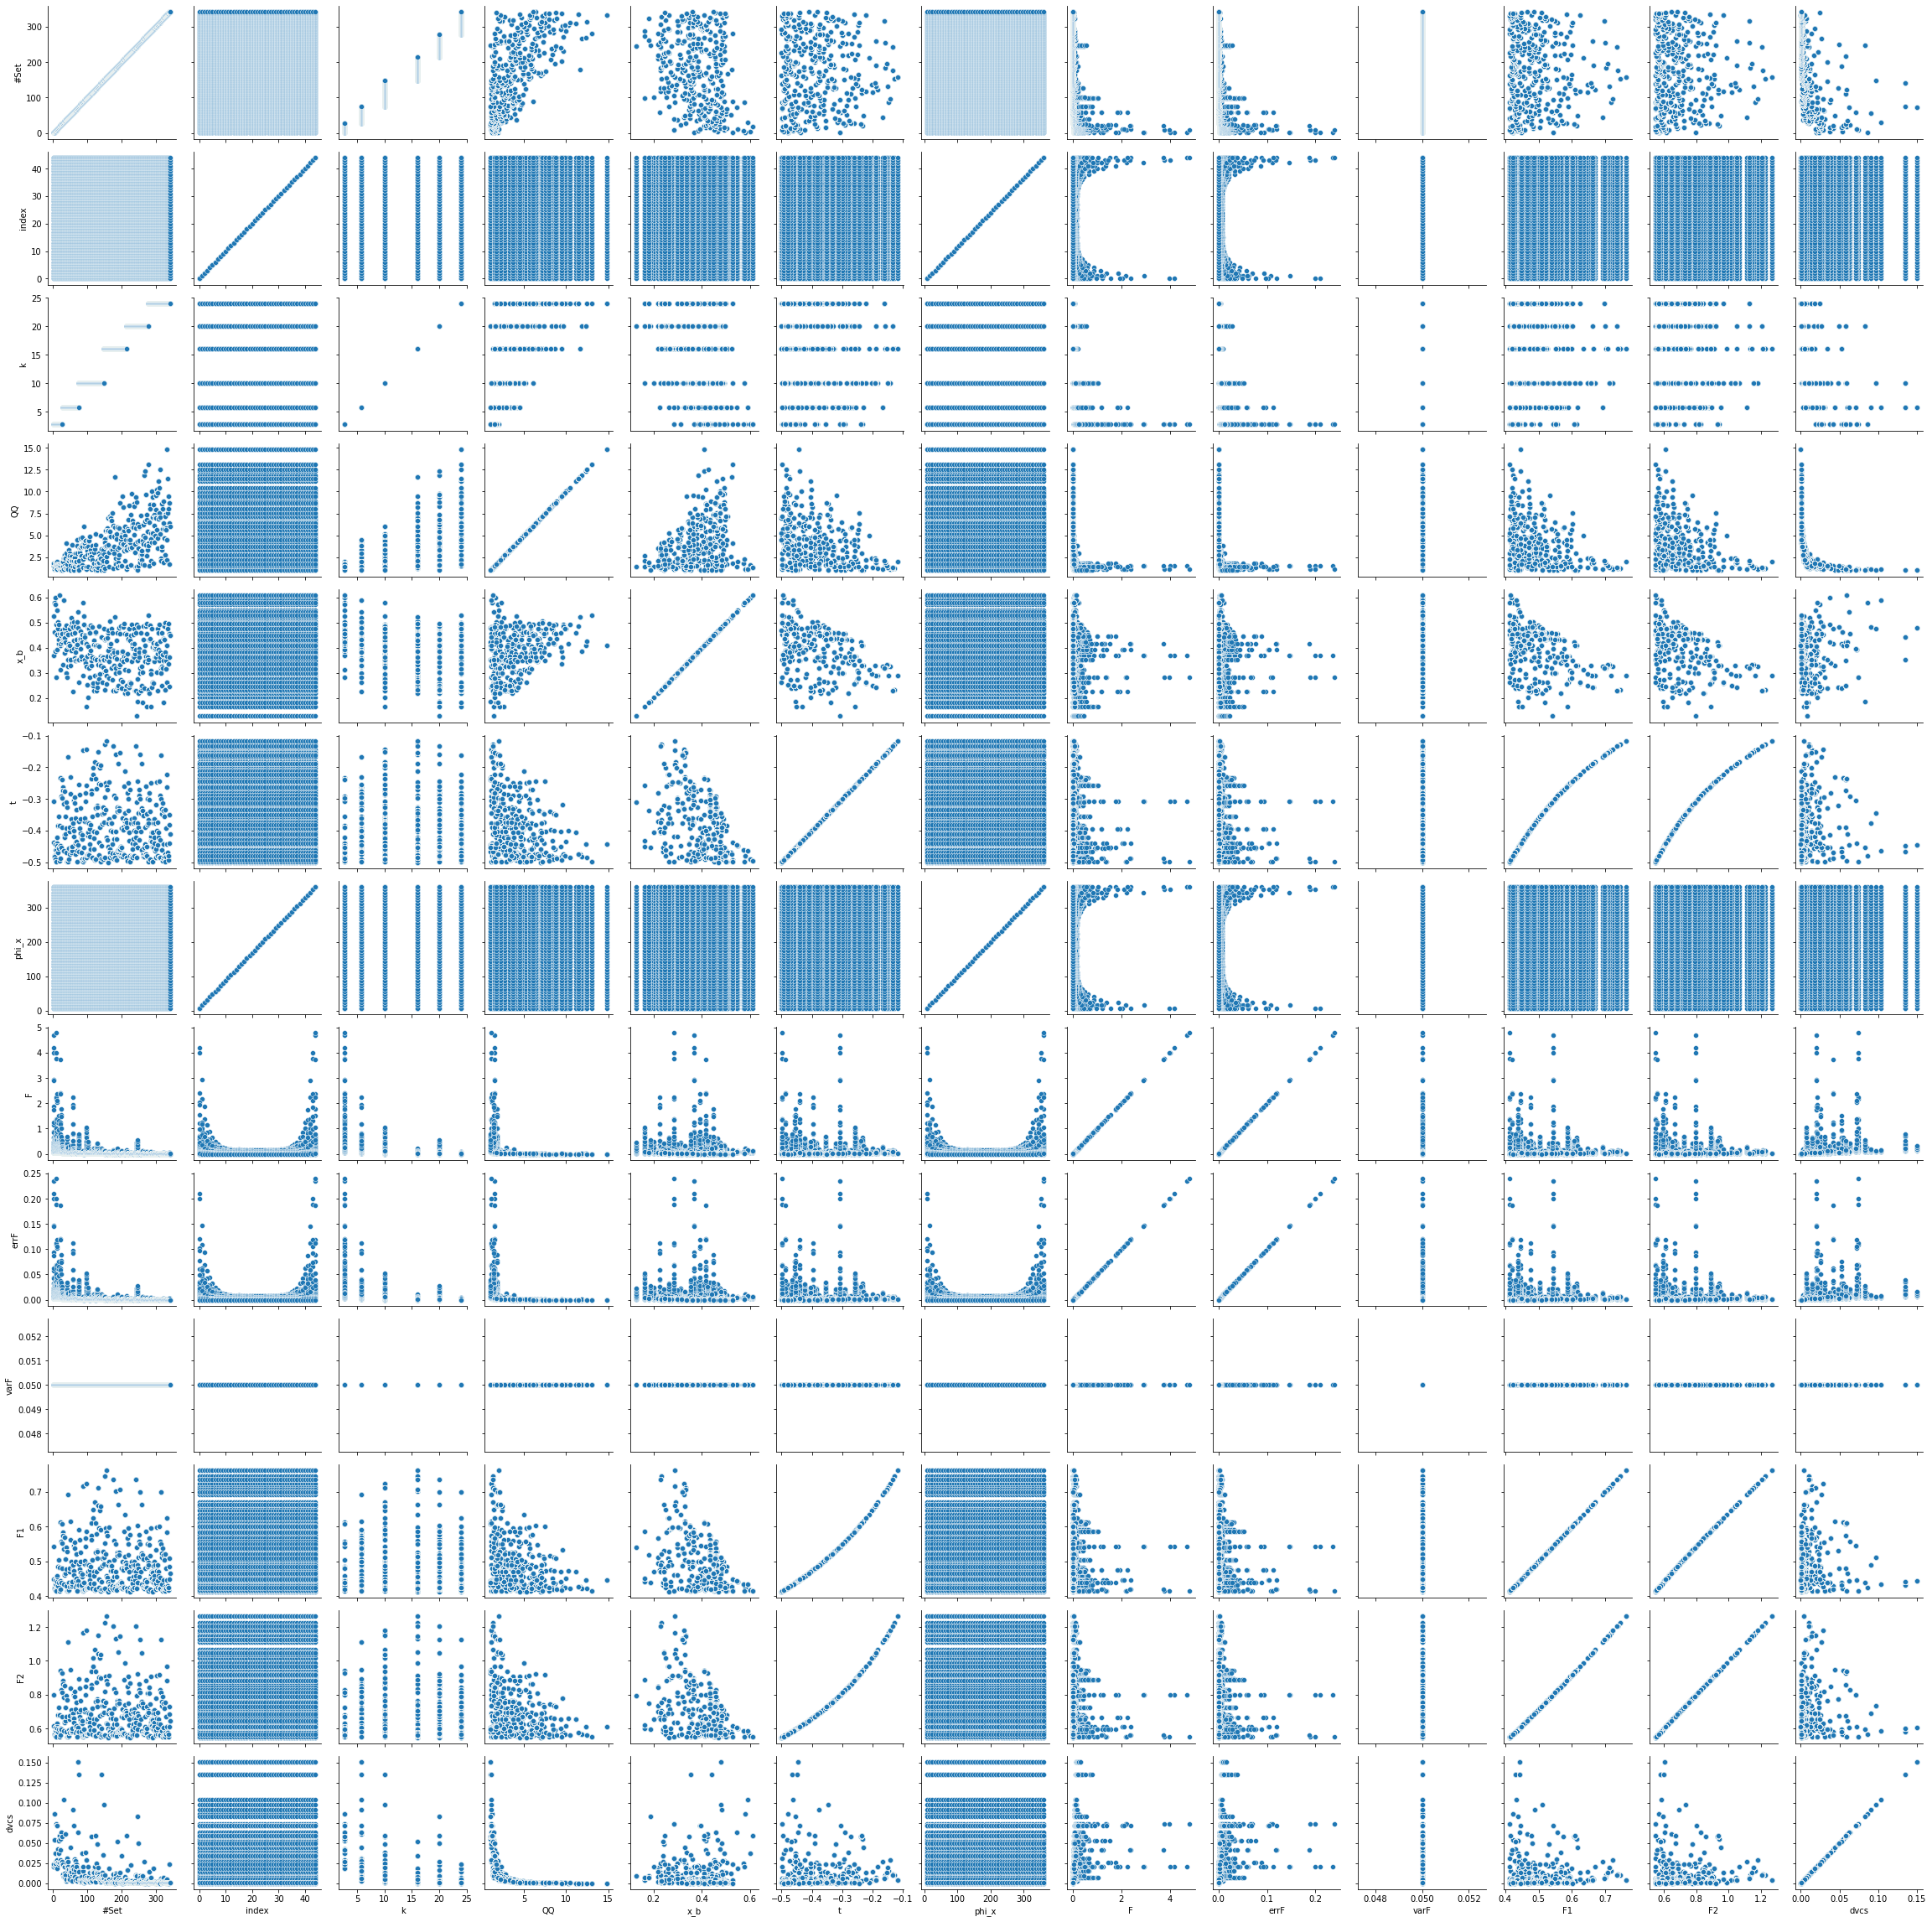

In [3]:
g = sns.PairGrid(df);
g.map(sns.scatterplot);

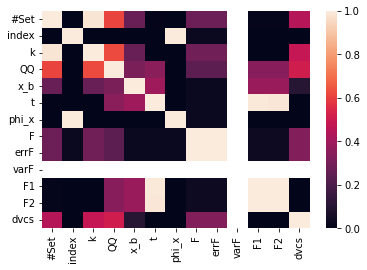

In [3]:
sns.heatmap(abs(df.corr()), xticklabels=df.columns.values, yticklabels=df.columns.values);

In [4]:
data = DvcsData(df)

In [54]:
kinematics = tf.keras.Input(shape=(4))
x1 = tf.keras.layers.Dense(100, activation="tanh")(kinematics)
d1 = tf.keras.layers.Dropout(0)(x1)
x2 = tf.keras.layers.Dense(100, activation="tanh")(d1)
d2 = tf.keras.layers.Dropout(0)(x2)
outputs = tf.keras.layers.Dense(4, activation="linear")(d2)
noncffInputs = tf.keras.Input(shape=(7))
#### phi, kin1, kin2, kin3, kin4, F1, F2 ####
total_FInputs = tf.keras.layers.concatenate([noncffInputs, outputs])
TotalF = TotalFLayer()(total_FInputs)

tfModel = tf.keras.Model(
    inputs=[kinematics, noncffInputs], outputs=TotalF, name="tfmodel")
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0.0000005, patience=25)

tfModel.compile(
    optimizer=tf.keras.optimizers.Adam(.0085),
    loss=tf.keras.losses.MeanSquaredError()
)

Wsave = tfModel.get_weights()

In [55]:
for n,layer in enumerate(tfModel.layers):
    if 'dropout' in layer.name:
        print(layer.rate)
        tfModel.layers[n].rate = 0.2

# tfModel = tf.keras.models.clone_model(tfModel)
tfModel.compile(
    optimizer=tf.keras.optimizers.Adam(.0085),
    loss=tf.keras.losses.MeanSquaredError()
)
for n,layer in enumerate(tfModel.layers):
    if 'dropout' in layer.name:
        print(layer.rate)

0
0
0.2
0.2


Model: "tfmodel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 100)          500         ['input_5[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 100)          0           ['dense_8[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 100)          10100       ['dropout_1[0][0]']              
                                                                                            

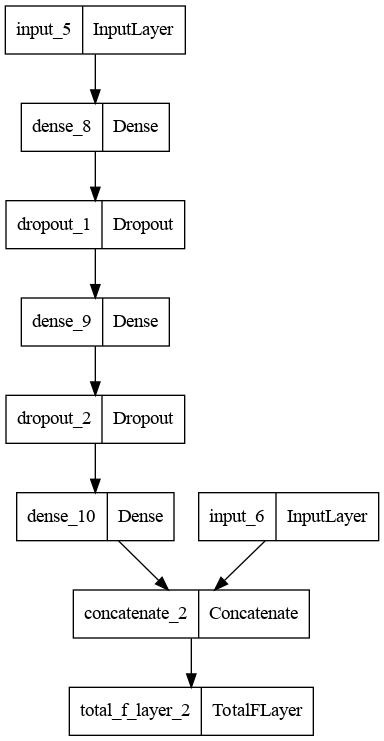

In [42]:
from keras.utils.vis_utils import plot_model
print(tfModel.summary())
plot_model(tfModel)

In [7]:
tfModel.compile(
    optimizer = tf.keras.optimizers.Adam(.0085),
    loss = tf.keras.losses.MeanSquaredError()
)

In [8]:
Wsave = tfModel.get_weights()

In [9]:
def get_total_error(experimental_values, expected_values):
  experimental_values, expected_values = list(experimental_values), list(expected_values)
  tot = 0
  for i,j in zip(experimental_values, expected_values):
    tot += abs(float(j) - float(i))
  return tot

def get_max_residual(x_values, experimental_values, expected_values):
  x_values, experimental_values, expected_values = list(x_values), list(experimental_values), list(expected_values)
  max = 0
  maxIndex = 0
  for n, (i,j) in enumerate(zip(experimental_values, expected_values)):
    residual = abs(float(j) - float(i))
    if residual > max:
      max = residual
      maxIndex = n
  return (x_values[n], max)

In [10]:
def get_rms(experimental_values, expected_values):  # normalized root mean square error
  experimental_values, expected_values = list(
      experimental_values), list(expected_values)
  tot = 0
  for i, j in zip(experimental_values, expected_values):
    tot += (float(j) - float(i))**2

  tot /= len(experimental_values)
  tot = np.sqrt(tot)
  tot /= (np.mean(expected_values))
  return tot

In [11]:
def F2VsPhi(dataframe,SetNum,xdat,cffs):
    plt.figure();
    f = BHDVCStf().curve_fit
    TempFvalSilces=dataframe[dataframe["#Set"]==SetNum]
    TempFvals=TempFvalSilces["F"]
    TempFvals_sigma=TempFvalSilces["errF"]
    temp_phi=TempFvalSilces["phi_x"]
    
    plt.errorbar(temp_phi,TempFvals,TempFvals_sigma,fmt='.',color='blue',label="Data")
    plt.xlim(0,368)
    temp_unit=(np.max(TempFvals)-np.min(TempFvals))/len(TempFvals)
    plt.ylim(np.min(TempFvals)-temp_unit,np.max(TempFvals)+temp_unit)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc=4,fontsize=10,handlelength=3)
    plt.title("Local fit with data set #"+str(SetNum),fontsize=20)

    calculated_points = f(xdat,cffs)

    plt.plot(temp_phi, calculated_points, 'g--', label='fit')
    file_name = "plot_set_number_{}.png".format(SetNum)
    plt.show();

In [12]:
def F2VsPhi_noPlot(dataframe, SetNum, xdat, cffs):
    f = BHDVCStf().curve_fit
    TempFvalSilces = dataframe[dataframe["#Set"] == SetNum]
    TempFvals = TempFvalSilces["F"]
    temp_phi = TempFvalSilces["phi_x"]

    calculated_points = f(xdat, cffs)

    return (calculated_points, get_total_error(calculated_points, TempFvals),
          get_max_residual(temp_phi, calculated_points, TempFvals),
          get_rms(calculated_points, TempFvals))

In [31]:
totSplit = data.getSet(0, itemsInSet=45).Kinematics
totSplit[data.getSet(0, itemsInSet=45).XnoCFF.columns] = data.getSet(0, itemsInSet=45).XnoCFF
totSplit.head()

k       QQ       x_b         t  phi_x        F1        F2
0  2.75  1.51576  0.369204 -0.306885    8.0  0.542867  0.798677
1  2.75  1.51576  0.369204 -0.306885   16.0  0.542867  0.798677
2  2.75  1.51576  0.369204 -0.306885   24.0  0.542867  0.798677
3  2.75  1.51576  0.369204 -0.306885   32.0  0.542867  0.798677
4  2.75  1.51576  0.369204 -0.306885   40.0  0.542867  0.798677

In [82]:
total_errors = {}
total_residuals = {}
total_rms_vals = {}
cffs_record = {}  # records all of the cffs
F_vals = {}


for epoch in np.arange(10, 21, 50):  # parse the upper region less thoroughly
  # 46 is greater than the 45 we need, but it will floor to 45
  for batch in np.arange(1,3, 5):
    for i in np.arange(0, 1):
      for d_rate in np.arange(0, 0.61, 0.2):
        for n,layer in enumerate(tfModel.layers):
          if 'dropout' in layer.name:
              tfModel.layers[n].rate = d_rate #changes the dropout rate for the model

        tfModel.compile(
          optimizer=tf.keras.optimizers.Adam(.0085),
          loss=tf.keras.losses.MeanSquaredError()
        )

        tfModel.set_weights(Wsave)  # resets the model
        setI = data.getSet(i, itemsInSet=45)

        tfModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleY(),  # one replica of samples from F vals
                    epochs=epoch, verbose=0, batch_size=batch, callbacks=[early_stopping_callback], validation_split=0.2)

        cffs = cffs_from_globalModel(tfModel, setI.Kinematics, numHL=4)

        new_xdat = np.transpose(setI.XnoCFF.to_numpy(dtype=np.float32))

        # Avoid recalculating F-values from cffs when that is what the model is predicting already

        F, total_error, max_residual, total_rms = F2VsPhi_noPlot(
            df, i + 1, new_xdat, cffs
        )  # runs the version without plotting to save time

        selection_key = (epoch, batch, d_rate, i)
        F_vals[selection_key] = np.array(F)
        cffs_record[selection_key] = np.array(cffs)
        total_errors[selection_key] = total_error
        total_residuals[selection_key] = max_residual
        total_rms_vals[selection_key] = total_rms

0.0
0.0
0.2
0.2
0.4
0.4
0.6000000000000001
0.6000000000000001


In [83]:
pd.Series(F_vals).reset_index()

level_0  level_1  level_2  level_3  \
0       10        1      0.0        0   
1       10        1      0.2        0   
2       10        1      0.4        0   
3       10        1      0.6        0   

                                                   0  
0  [3.8824463, 2.6934042, 1.778879, 1.2021415, 0....  
1  [4.2221007, 2.9290175, 1.9346311, 1.3077447, 0...  
2  [4.3703094, 3.064352, 2.0602183, 1.4273927, 1....  
3  [4.4363065, 3.1468694, 2.1553721, 1.5304221, 1...

In [74]:
F_vals = pd.Series(F_vals).reset_index()
F_vals.columns = ["Epoch", "Batch", "Dropout Rate", "Set", "Calculated Points"]

cffs_record = pd.Series(cffs_record).reset_index()
cffs_record.columns = ["Epoch", "Batch", "Dropout Rate", "Set", "Calculated CFFs"]

total_errors = pd.Series(total_errors).reset_index()
total_errors.columns = ["Epoch", "Batch", "Dropout Rate", "Set", "MAE"]

total_residuals = pd.Series(total_residuals).reset_index()
total_residuals.columns = ["Epoch", "Batch", "Dropout Rate", "Set", "Max Residual"]

total_rms_vals = pd.Series(total_rms_vals).reset_index()
total_rms_vals.columns = ["Epoch", "Batch", "Dropout Rate", "Set", "NRMSE"]

total_metrics = F_vals.merge(cffs_record).merge(
    total_errors).merge(total_residuals).merge(total_rms_vals)

total_metrics['Set'] += 1

In [75]:
total_metrics

Epoch  Batch  Dropout Rate  Set  \
0     10      1           0.0    1   
1     10      1           0.2    1   
2     10      1           0.4    1   
3     10      1           0.6    1   

                                   Calculated Points  \
0  [4.543119, 3.1307967, 2.0449522, 1.360728, 0.9...   
1  [4.431134, 3.038374, 1.9674462, 1.2924554, 0.8...   
2  [4.199489, 2.8412745, 1.7970448, 1.1390635, 0....   
3  [4.293388, 2.9112327, 1.8484187, 1.1784871, 0....   

                                     Calculated CFFs       MAE  \
0      [1.792805, 1.0719264, 1.8218932, 0.027245648]  3.859079   
1  [1.8248991, 0.38493443, 0.45147288, -0.042705223]  4.570754   
2      [1.1537962, 1.921655, 2.6698456, -0.14080854]  7.820996   
3   [1.7913582, -2.6082845, 0.70540655, -0.15310317]  7.457785   

                  Max Residual     NRMSE  
0  (360.0, 0.6387214399719241)  0.213196  
1  (360.0, 0.5157313085937503)  0.182808  
2   (360.0, 0.264744732513428)  0.245321  
3  (360.0, 0.3720264173889163)  0.238816

In [76]:
actual_values = pd.read_csv('test_data/BKM_pseudodata2_with_CFFS.csv')
actual_values.rename(columns={"#Set":"Set"}, inplace=True)
actual_values['Set'] = actual_values['Set'].astype(int)
actual_values

Set  index      k       QQ       x_b         t  phi_x         F  \
0        1      0   2.75  1.51576  0.369204 -0.306885      8  4.193970   
1        1      1   2.75  1.51576  0.369204 -0.306885     16  2.950900   
2        1      2   2.75  1.51576  0.369204 -0.306885     24  1.865680   
3        1      3   2.75  1.51576  0.369204 -0.306885     32  1.139000   
4        1      4   2.75  1.51576  0.369204 -0.306885     40  0.871079   
...    ...    ...    ...      ...       ...       ...    ...       ...   
15385  342     40  24.00  6.04013  0.448435 -0.410593    328  0.001685   
15386  342     41  24.00  6.04013  0.448435 -0.410593    336  0.001892   
15387  342     42  24.00  6.04013  0.448435 -0.410593    344  0.002007   
15388  342     43  24.00  6.04013  0.448435 -0.410593    352  0.001744   
15389  342     44  24.00  6.04013  0.448435 -0.410593    360  0.001946   

         sigmaF  varF        F1        F2       ReH      ReE  ReHTilde  \
0      0.209699  0.05  0.542867  0.798677  0.743515 -1.58545   3.34929   
1      0.147545  0.05  0.542867  0.798677  0.743515 -1.58545   3.34929   
2      0.093284  0.05  0.542867  0.798677  0.743515 -1.58545   3.34929   
3      0.056950  0.05  0.542867  0.798677  0.743515 -1.58545   3.34929   
4      0.043554  0.05  0.542867  0.798677  0.743515 -1.58545   3.34929   
...         ...   ...       ...       ...       ...      ...       ...   
15385  0.000084  0.05  0.465849  0.646508  1.245120 -2.14931   4.27622   
15386  0.000095  0.05  0.465849  0.646508  1.245120 -2.14931   4.27622   
15387  0.000100  0.05  0.465849  0.646508  1.245120 -2.14931   4.27622   
15388  0.000087  0.05  0.465849  0.646508  1.245120 -2.14931   4.27622   
15389  0.000097  0.05  0.465849  0.646508  1.245120 -2.14931   4.27622   

           dvcs  
0      0.020660  
1      0.020660  
2      0.020660  
3      0.020660  
4      0.020660  
...         ...  
15385  0.001021  
15386  0.001021  
15387  0.001021  
15388  0.001021  
15389  0.001021  

[15390 rows x 16 columns]

In [77]:
def collapse(lst): #if all elements of a list are the same, collapse the list into a single item
    try:
        iter(lst) #checks if the item is a list
    except:
        return lst
    
    
    for n,i in enumerate(lst[:-1]):
        if i != lst[n+1]:
            return lst
    return lst[0]

In [78]:
actual_values_listified = pd.DataFrame(columns = actual_values.columns)

for i in range(1,actual_values['Set'].max() + 1):
    tempdf = actual_values.query('Set==@i')
    tempdf = tempdf.stack().reset_index(level=0, drop=True)
    tempdf = tempdf.groupby(tempdf.index).apply(list).to_frame().transpose()
    actual_values_listified = pd.concat((actual_values_listified, tempdf), axis=0)
    
for column in actual_values_listified.columns:
    actual_values_listified[column] = actual_values_listified[column].apply(collapse)
actual_values = actual_values_listified
del actual_values_listified

In [79]:
overall = actual_values.merge(total_metrics, on='Set').drop(columns=['k','QQ','x_b','t','F1','F2','dvcs'])

In [80]:
overall.head()

Set                                              index  \
0  1.0  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
1  1.0  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
2  1.0  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
3  1.0  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   

                                               phi_x  \
0  [8.0, 16.0, 24.0, 32.0, 40.0, 48.0, 56.0, 64.0...   
1  [8.0, 16.0, 24.0, 32.0, 40.0, 48.0, 56.0, 64.0...   
2  [8.0, 16.0, 24.0, 32.0, 40.0, 48.0, 56.0, 64.0...   
3  [8.0, 16.0, 24.0, 32.0, 40.0, 48.0, 56.0, 64.0...   

                                                   F  \
0  [4.19397, 2.9509, 1.86568, 1.139, 0.871079, 0....   
1  [4.19397, 2.9509, 1.86568, 1.139, 0.871079, 0....   
2  [4.19397, 2.9509, 1.86568, 1.139, 0.871079, 0....   
3  [4.19397, 2.9509, 1.86568, 1.139, 0.871079, 0....   

                                              sigmaF  varF       ReH      ReE  \
0  [0.209699, 0.147545, 0.0932839, 0.05695, 0.043...  0.05  0.743515 -1.58545   
1  [0.209699, 0.147545, 0.0932839, 0.05695, 0.043...  0.05  0.743515 -1.58545   
2  [0.209699, 0.147545, 0.0932839, 0.05695, 0.043...  0.05  0.743515 -1.58545   
3  [0.209699, 0.147545, 0.0932839, 0.05695, 0.043...  0.05  0.743515 -1.58545   

   ReHTilde  Epoch  Batch  Dropout Rate  \
0   3.34929     10      1           0.0   
1   3.34929     10      1           0.2   
2   3.34929     10      1           0.4   
3   3.34929     10      1           0.6   

                                   Calculated Points  \
0  [4.543119, 3.1307967, 2.0449522, 1.360728, 0.9...   
1  [4.431134, 3.038374, 1.9674462, 1.2924554, 0.8...   
2  [4.199489, 2.8412745, 1.7970448, 1.1390635, 0....   
3  [4.293388, 2.9112327, 1.8484187, 1.1784871, 0....   

                                     Calculated CFFs       MAE  \
0      [1.792805, 1.0719264, 1.8218932, 0.027245648]  3.859079   
1  [1.8248991, 0.38493443, 0.45147288, -0.042705223]  4.570754   
2      [1.1537962, 1.921655, 2.6698456, -0.14080854]  7.820996   
3   [1.7913582, -2.6082845, 0.70540655, -0.15310317]  7.457785   

                  Max Residual     NRMSE  
0  (360.0, 0.6387214399719241)  0.213196  
1  (360.0, 0.5157313085937503)  0.182808  
2   (360.0, 0.264744732513428)  0.245321  
3  (360.0, 0.3720264173889163)  0.238816

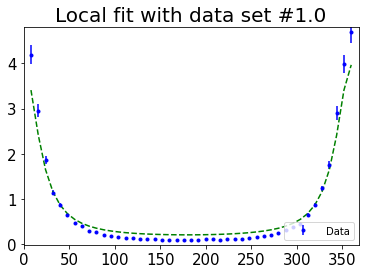

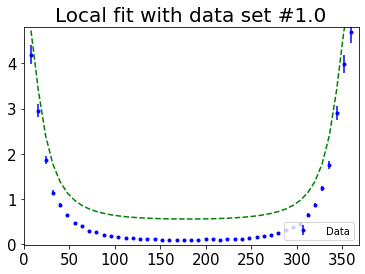

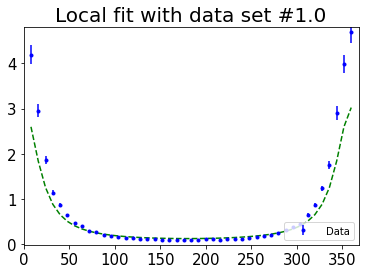

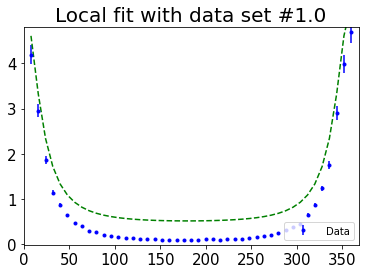

In [81]:
for index, row in overall.iterrows():
    setI = data.getSet(row['Set'] - 1, itemsInSet=45)

    tfModel.set_weights(Wsave)

    tfModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleY(), # one replica of samples from F vals
                        epochs=row['Epoch'], verbose=0, batch_size=row['Batch'], callbacks=[early_stopping_callback])


    cffs = cffs_from_globalModel(tfModel, setI.Kinematics, numHL=4)

    by_set.append(cffs)

    new_xdat = np.transpose(setI.XnoCFF.to_numpy(dtype=np.float32)) #NB: Could rewrite BHDVCS curve_fit to not require transposition

    # Avoid recalculating F-values from cffs when that is what the model is predicting already
    F2VsPhi(df,row['Set'],new_xdat,cffs);

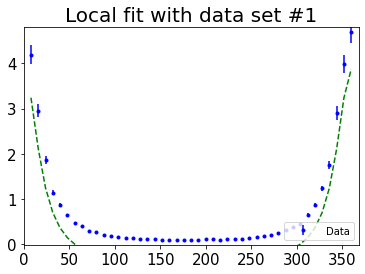

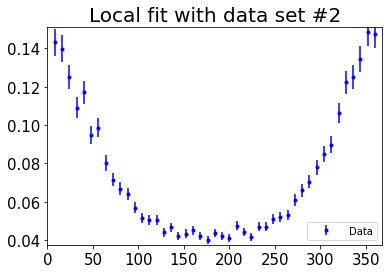

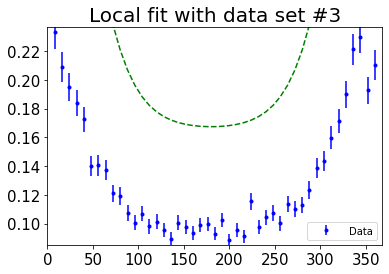

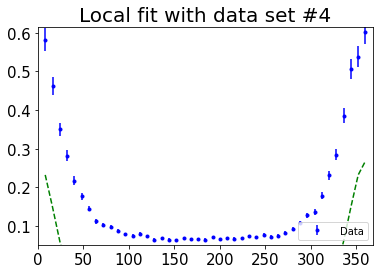

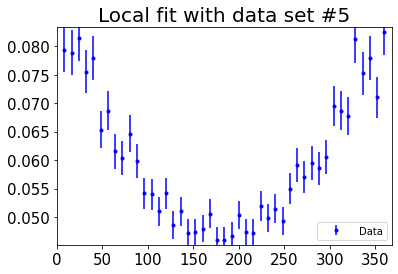

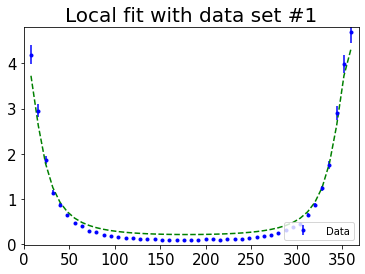

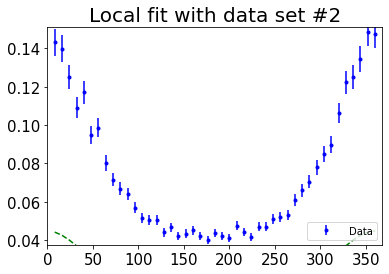

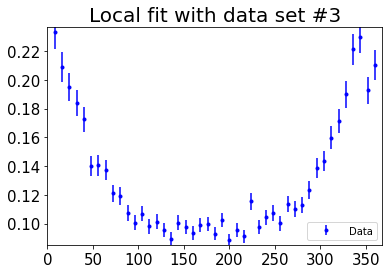

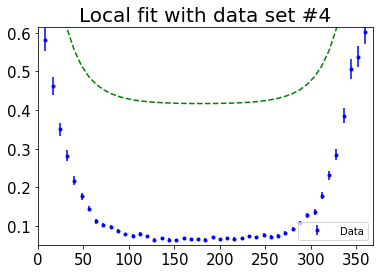

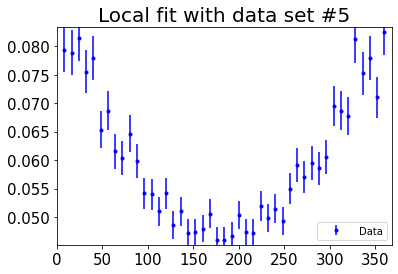

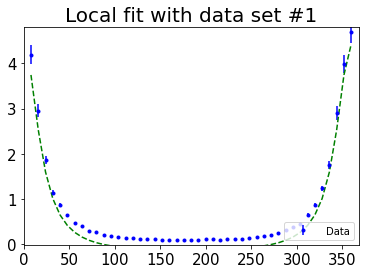

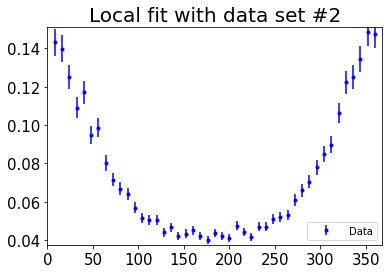

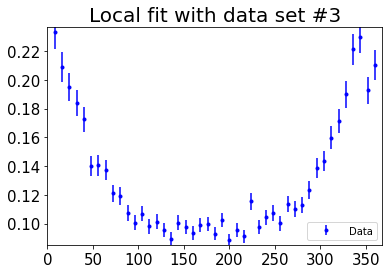

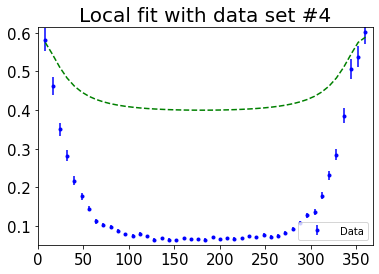

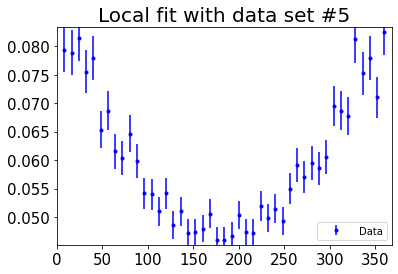

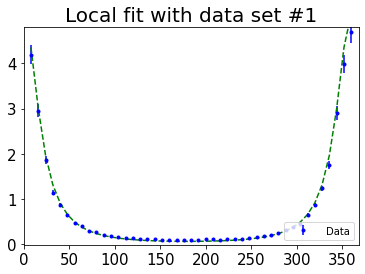

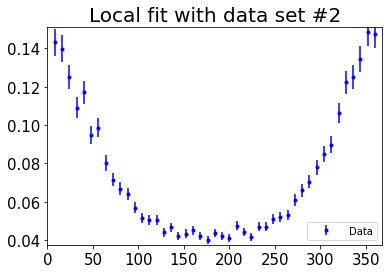

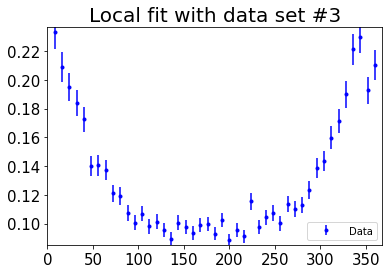

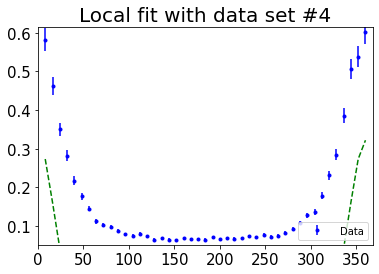

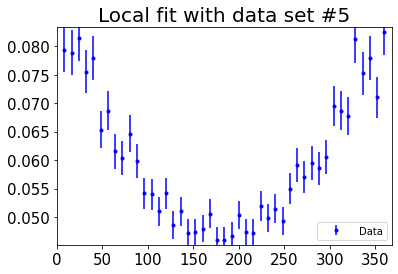

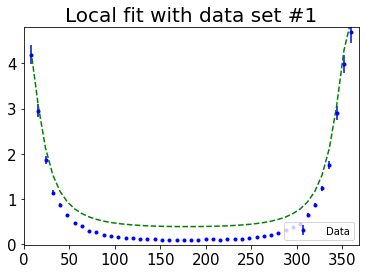

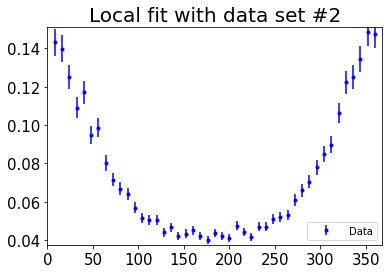

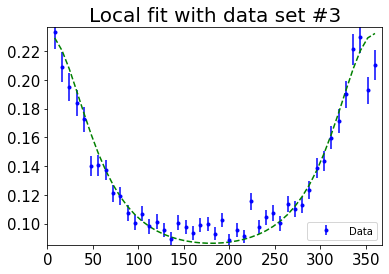

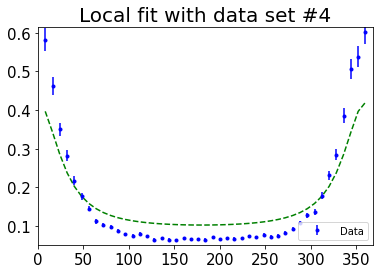

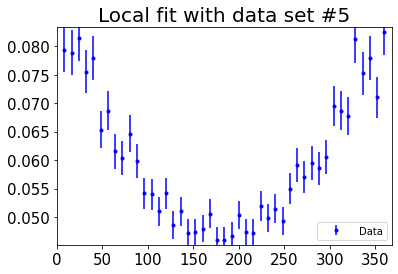

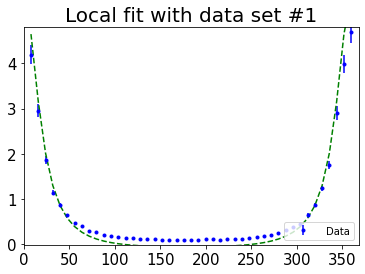

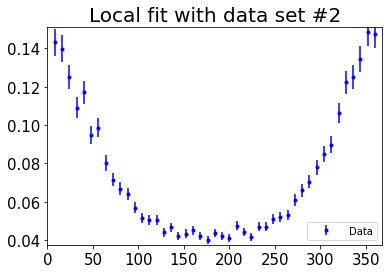

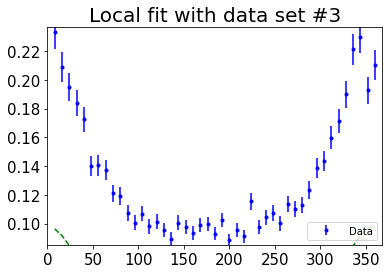

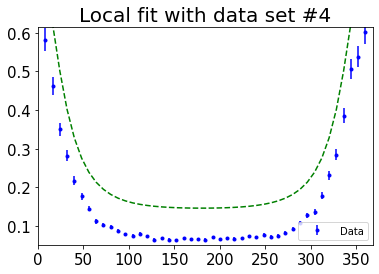

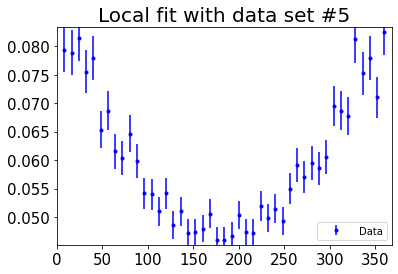

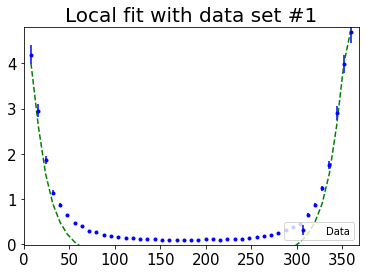

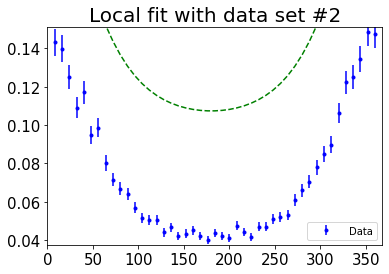

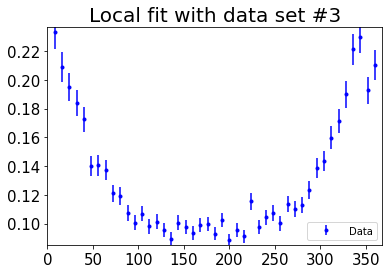

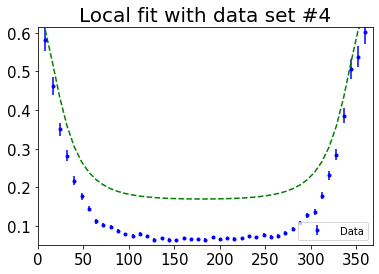

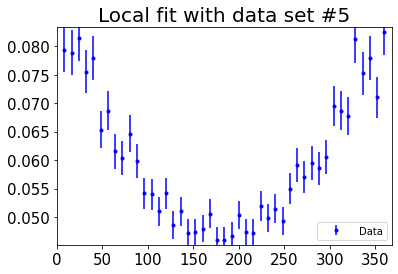

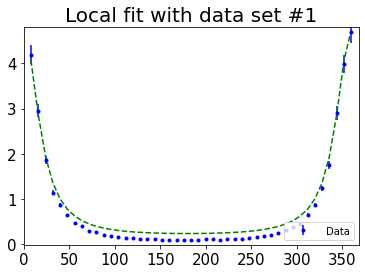

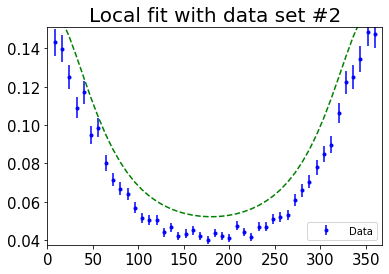

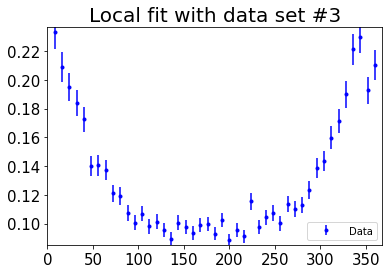

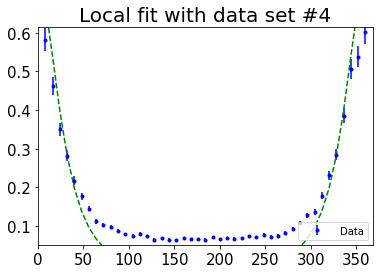

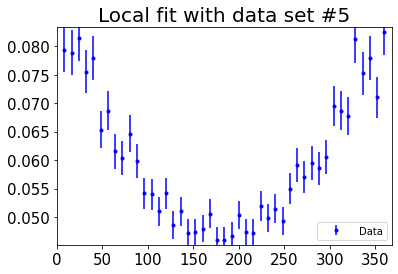

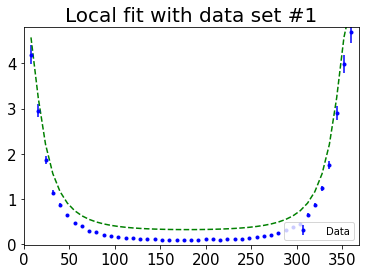

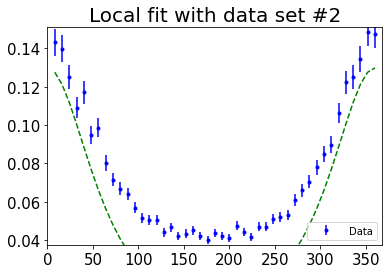

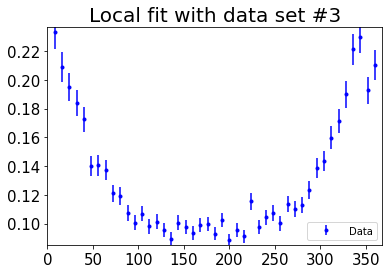

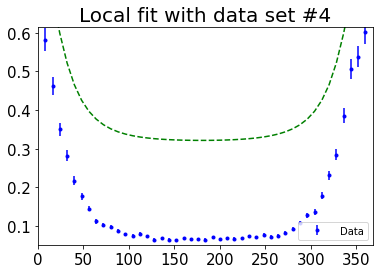

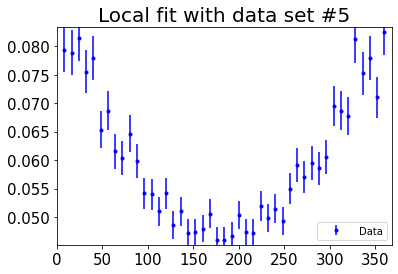

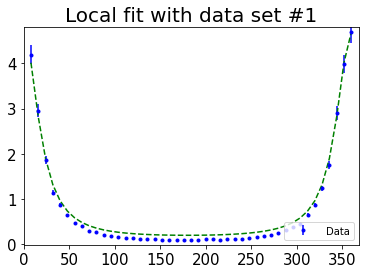

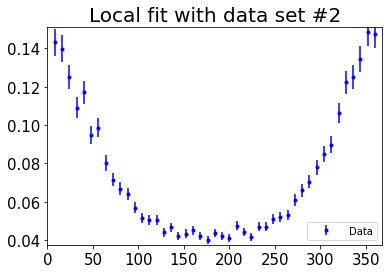

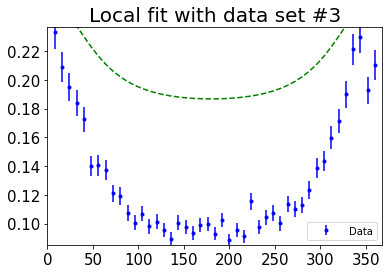

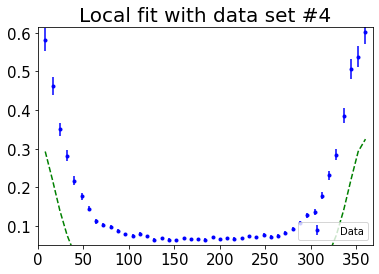

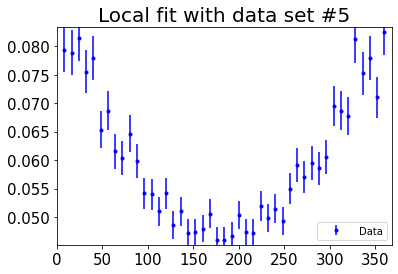

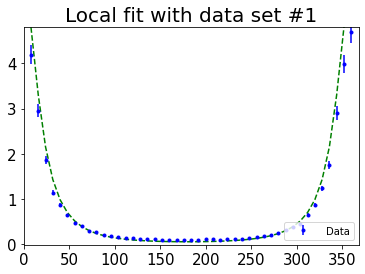

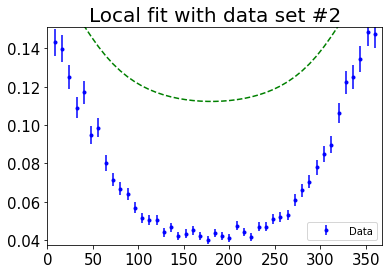

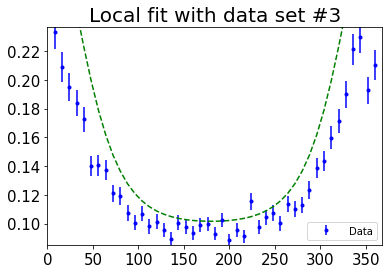

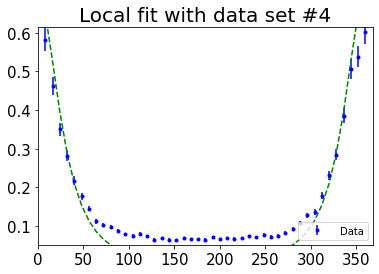

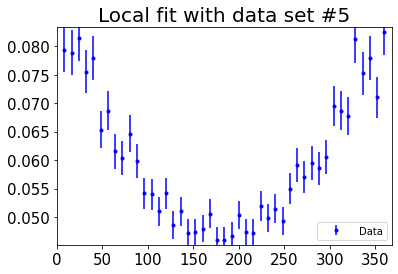

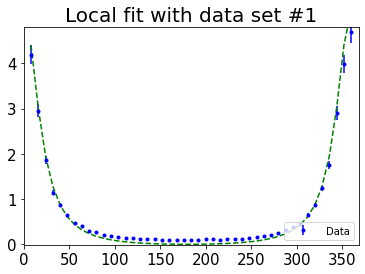

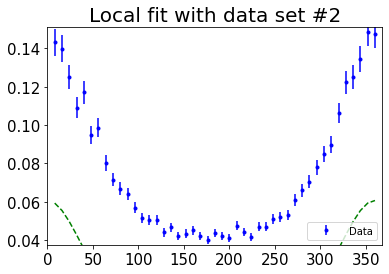

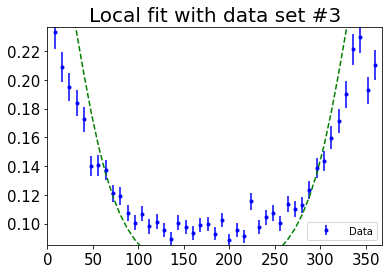

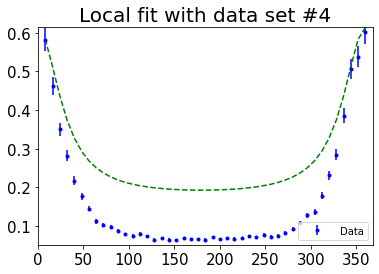

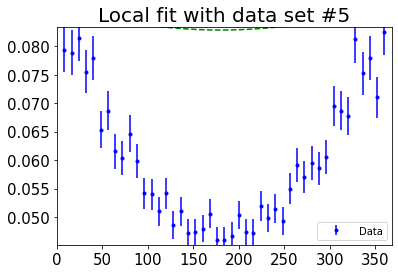

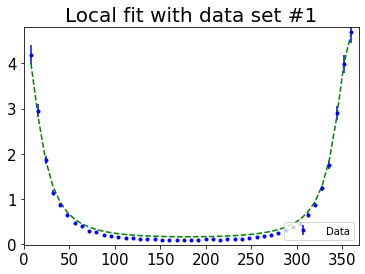

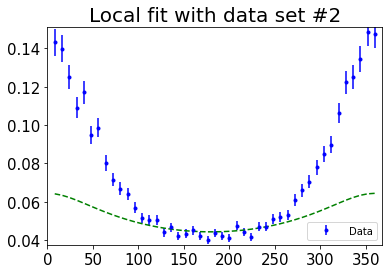

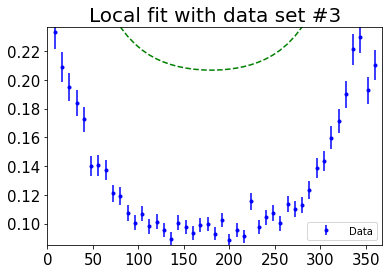

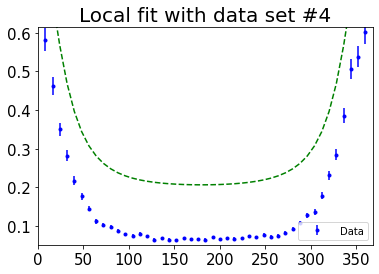

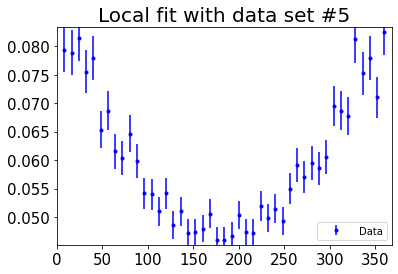

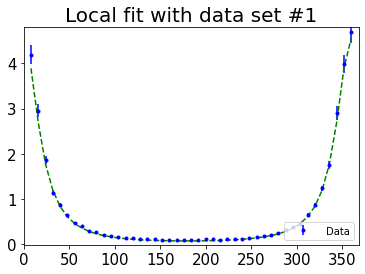

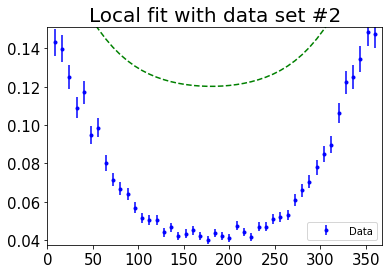

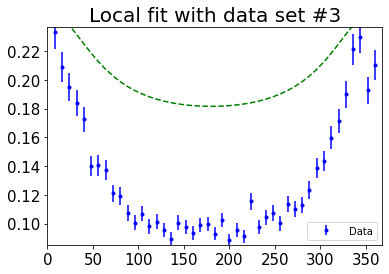

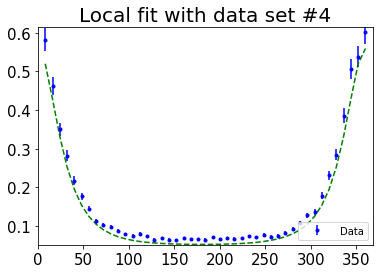

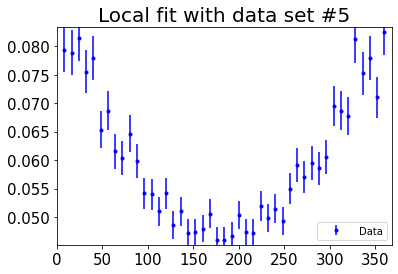

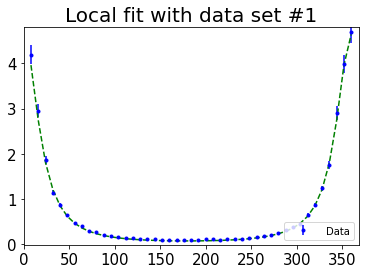

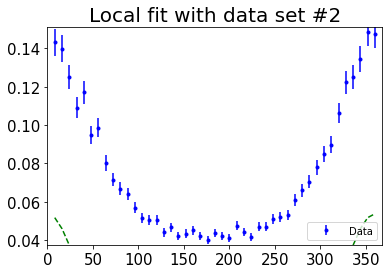

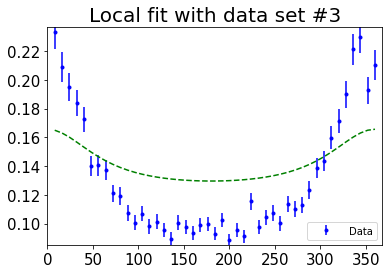

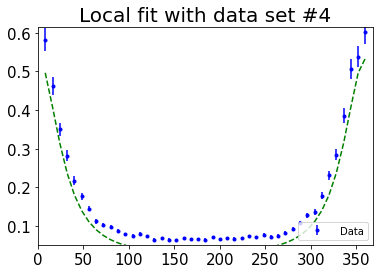

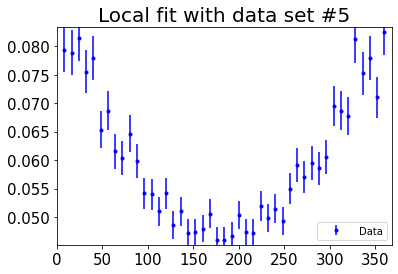

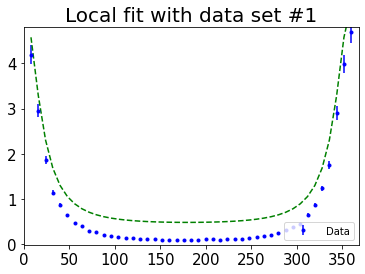

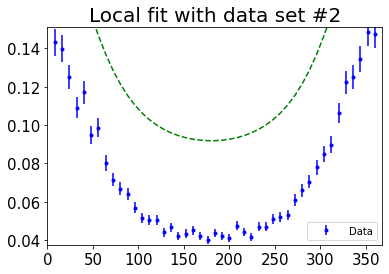

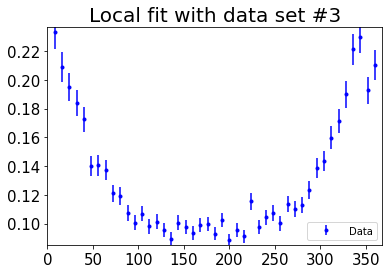

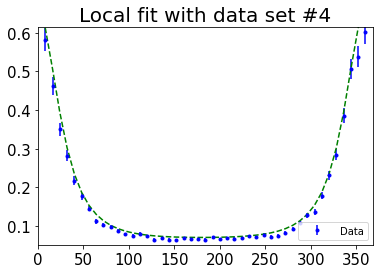

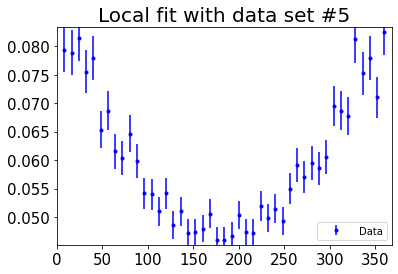

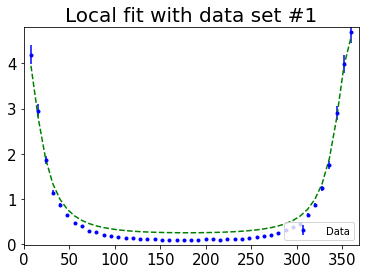

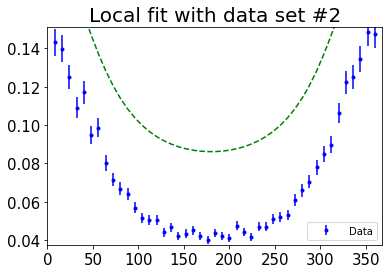

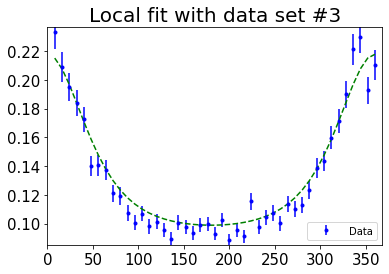

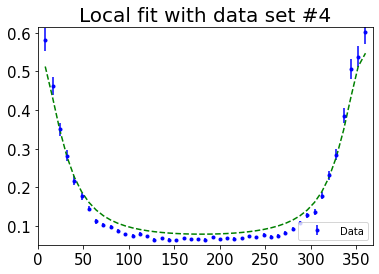

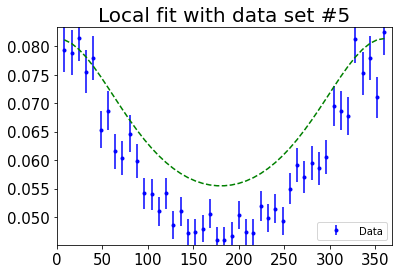

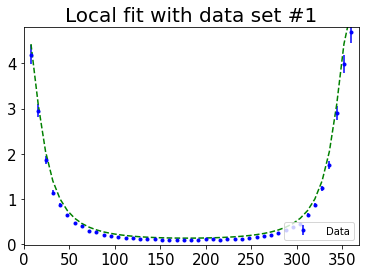

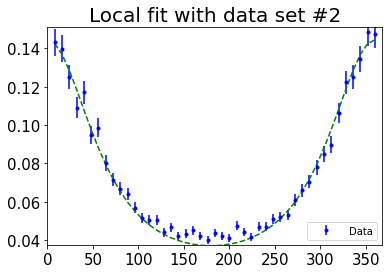

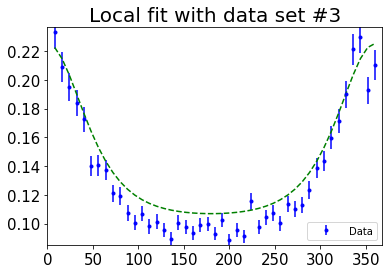

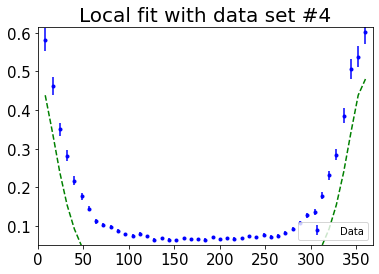

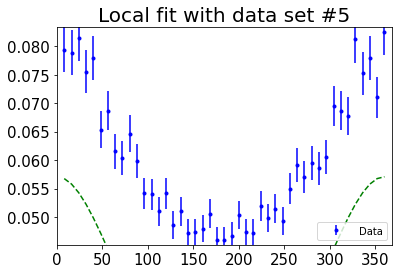

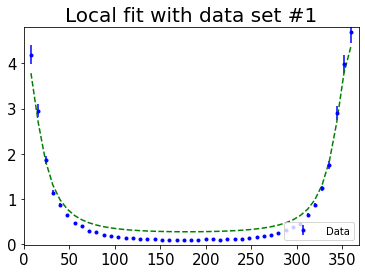

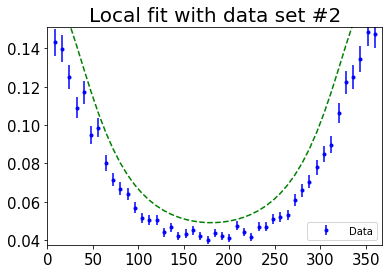

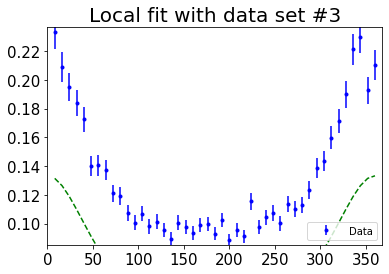

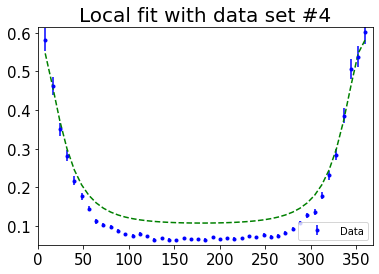

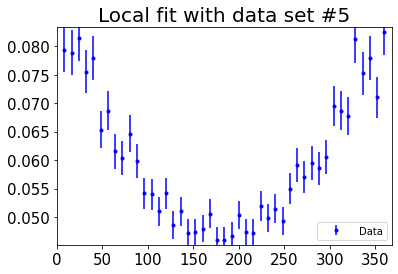

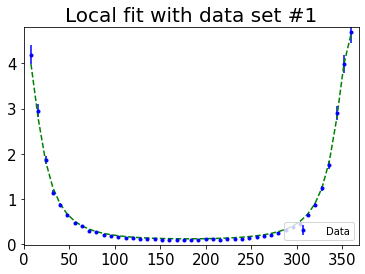

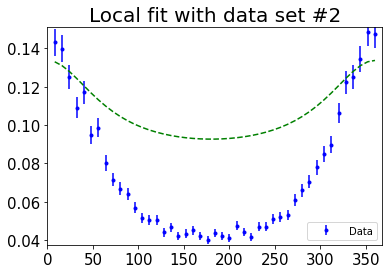

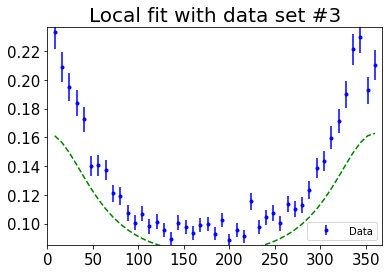

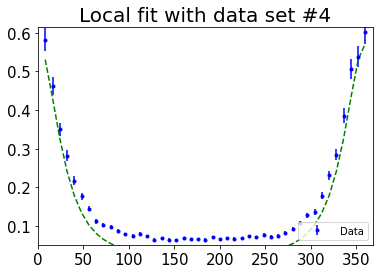

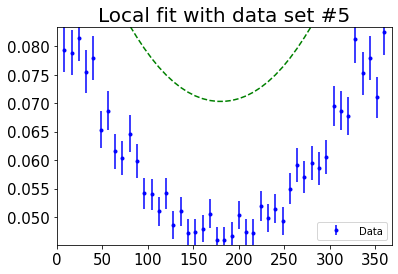

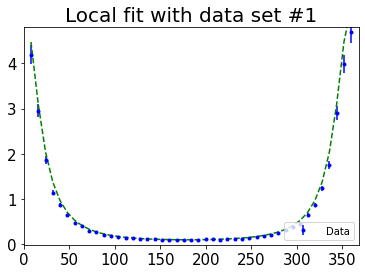

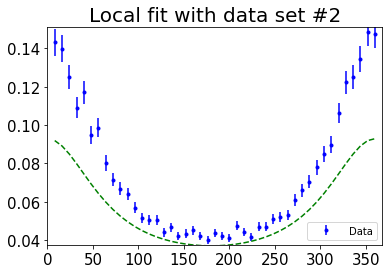

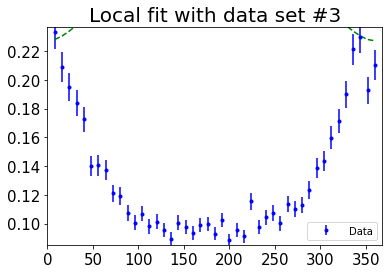

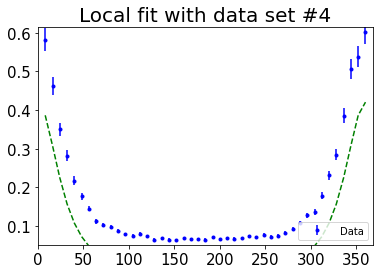

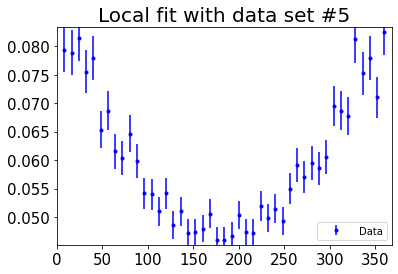

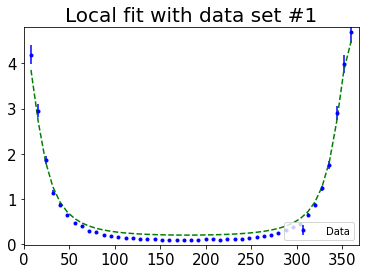

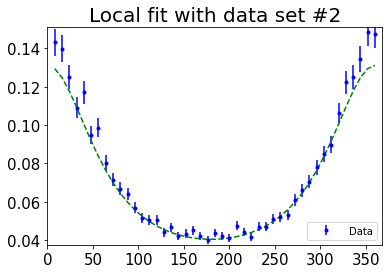

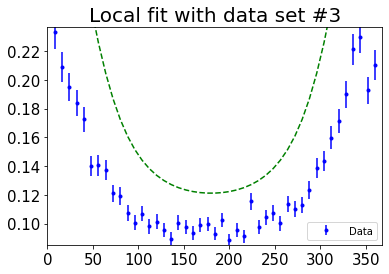

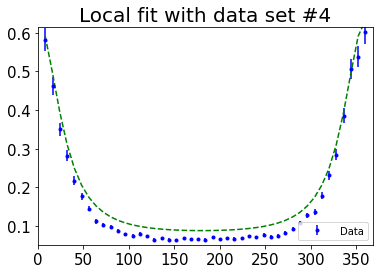

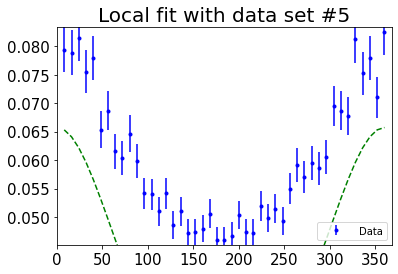

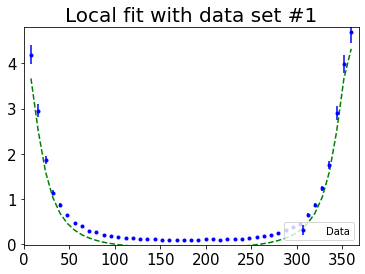

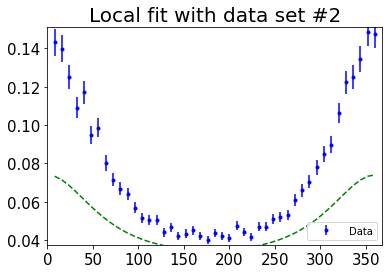

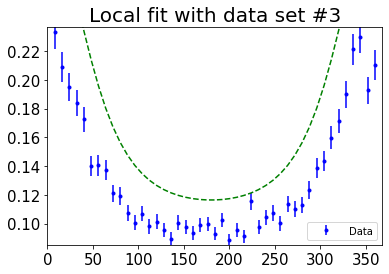

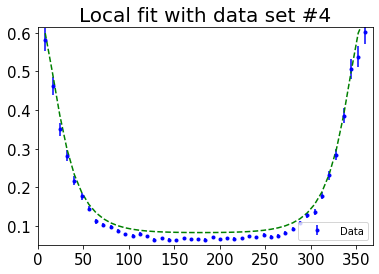

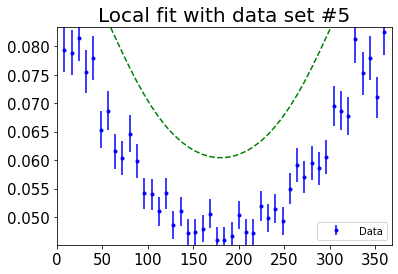

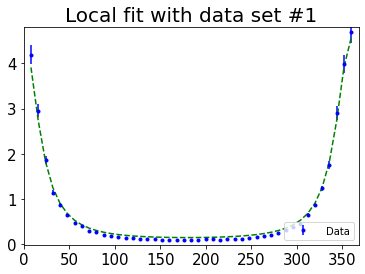

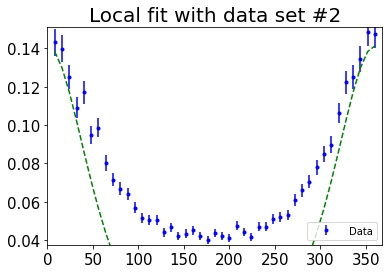

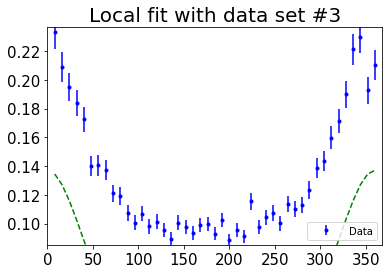

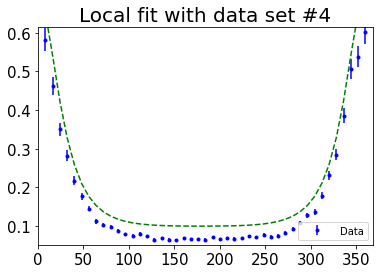

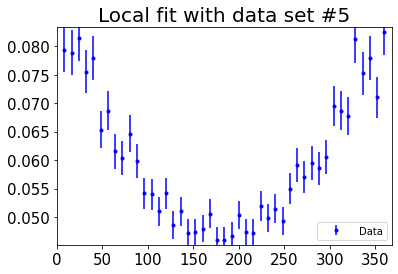

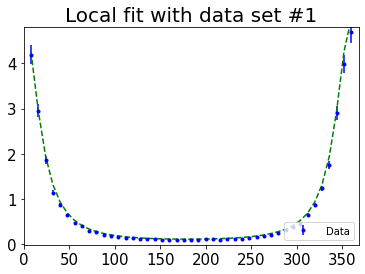

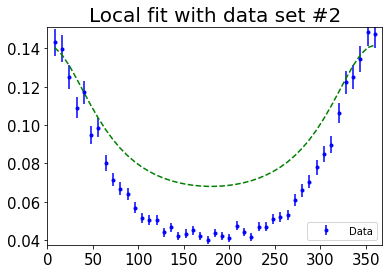

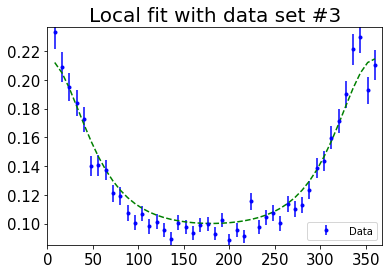

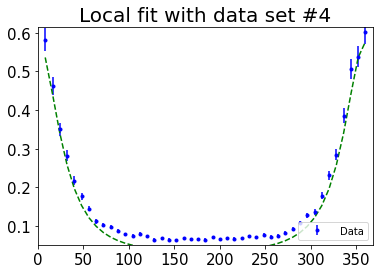

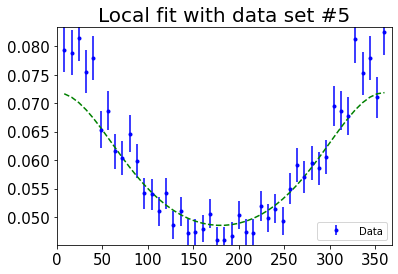

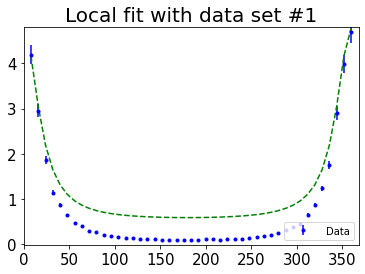

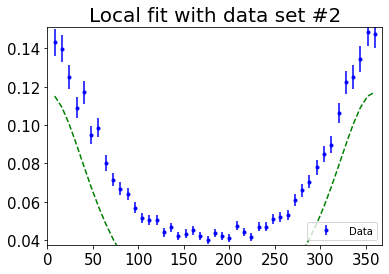

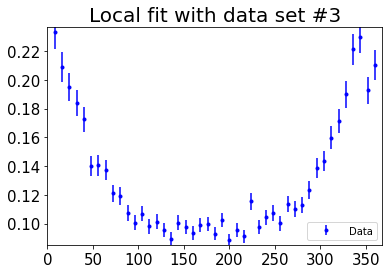

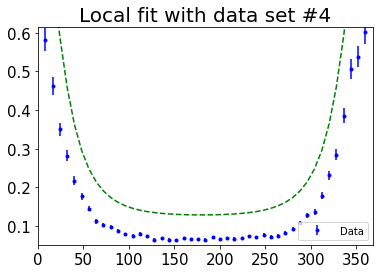

KeyboardInterrupt: 

In [71]:
for epoch in np.arange(5,46,5):
    for batch in np.arange(1,6,1):
        by_set = []
        for i in range(5):
            setI = data.getSet(i, itemsInSet=45)

            tfModel.set_weights(Wsave)

            tfModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleY(), # one replica of samples from F vals
                                epochs=epoch, verbose=0, batch_size=batch, callbacks=[early_stopping_callback])


            cffs = cffs_from_globalModel(tfModel, setI.Kinematics, numHL=4)

            new_xdat = np.transpose(setI.XnoCFF.to_numpy(dtype=np.float32))

            # Avoid recalculating F-values from cffs when that is what the model is predicting already

            F2VsPhi(
              df, i + 1, new_xdat, cffs
            )  # runs the version without plotting to save time

In [ ]:
colors = ['red', 'blue', 'black', 'orange', 'lime']
fig, ax = plt.subplots(1, 5, figsize=(10*9, 7*5));

by_batch_size = np.ndarray((9,5), dtype=object)

for i in range(9):
  for j in range(5):
    by_batch_size[i][j] = []

for n,err in enumerate(total_errors.keys()):
  if by_batch_size[err[0]//5 - 1][err[1] - 1] == []:
    by_batch_size[err[0]//5 - 1][err[1] - 1] = [total_errors[err]]
  else:
    by_batch_size[err[0]//5 - 1][err[1] - 1] += [total_errors[err]]
  # by_batch_size[err[0]//5 - 1][err[1] - 1].scatter(err[2], total_errors[err], c = colors[err[2]], label="set #" + str(err[2]));
  # by_batch_size[err[0]//5 - 1][err[1] - 1].set_ylim(bottom = 0, top = max(total_errors.values()));
  # by_batch_size[err[0]//5 - 1][err[1] - 1].set_title("Batch Size of " + str(err[1]) + " With " + str(err[0]) + " Epochs")

# ax[8][4].legend();
by_batch_size

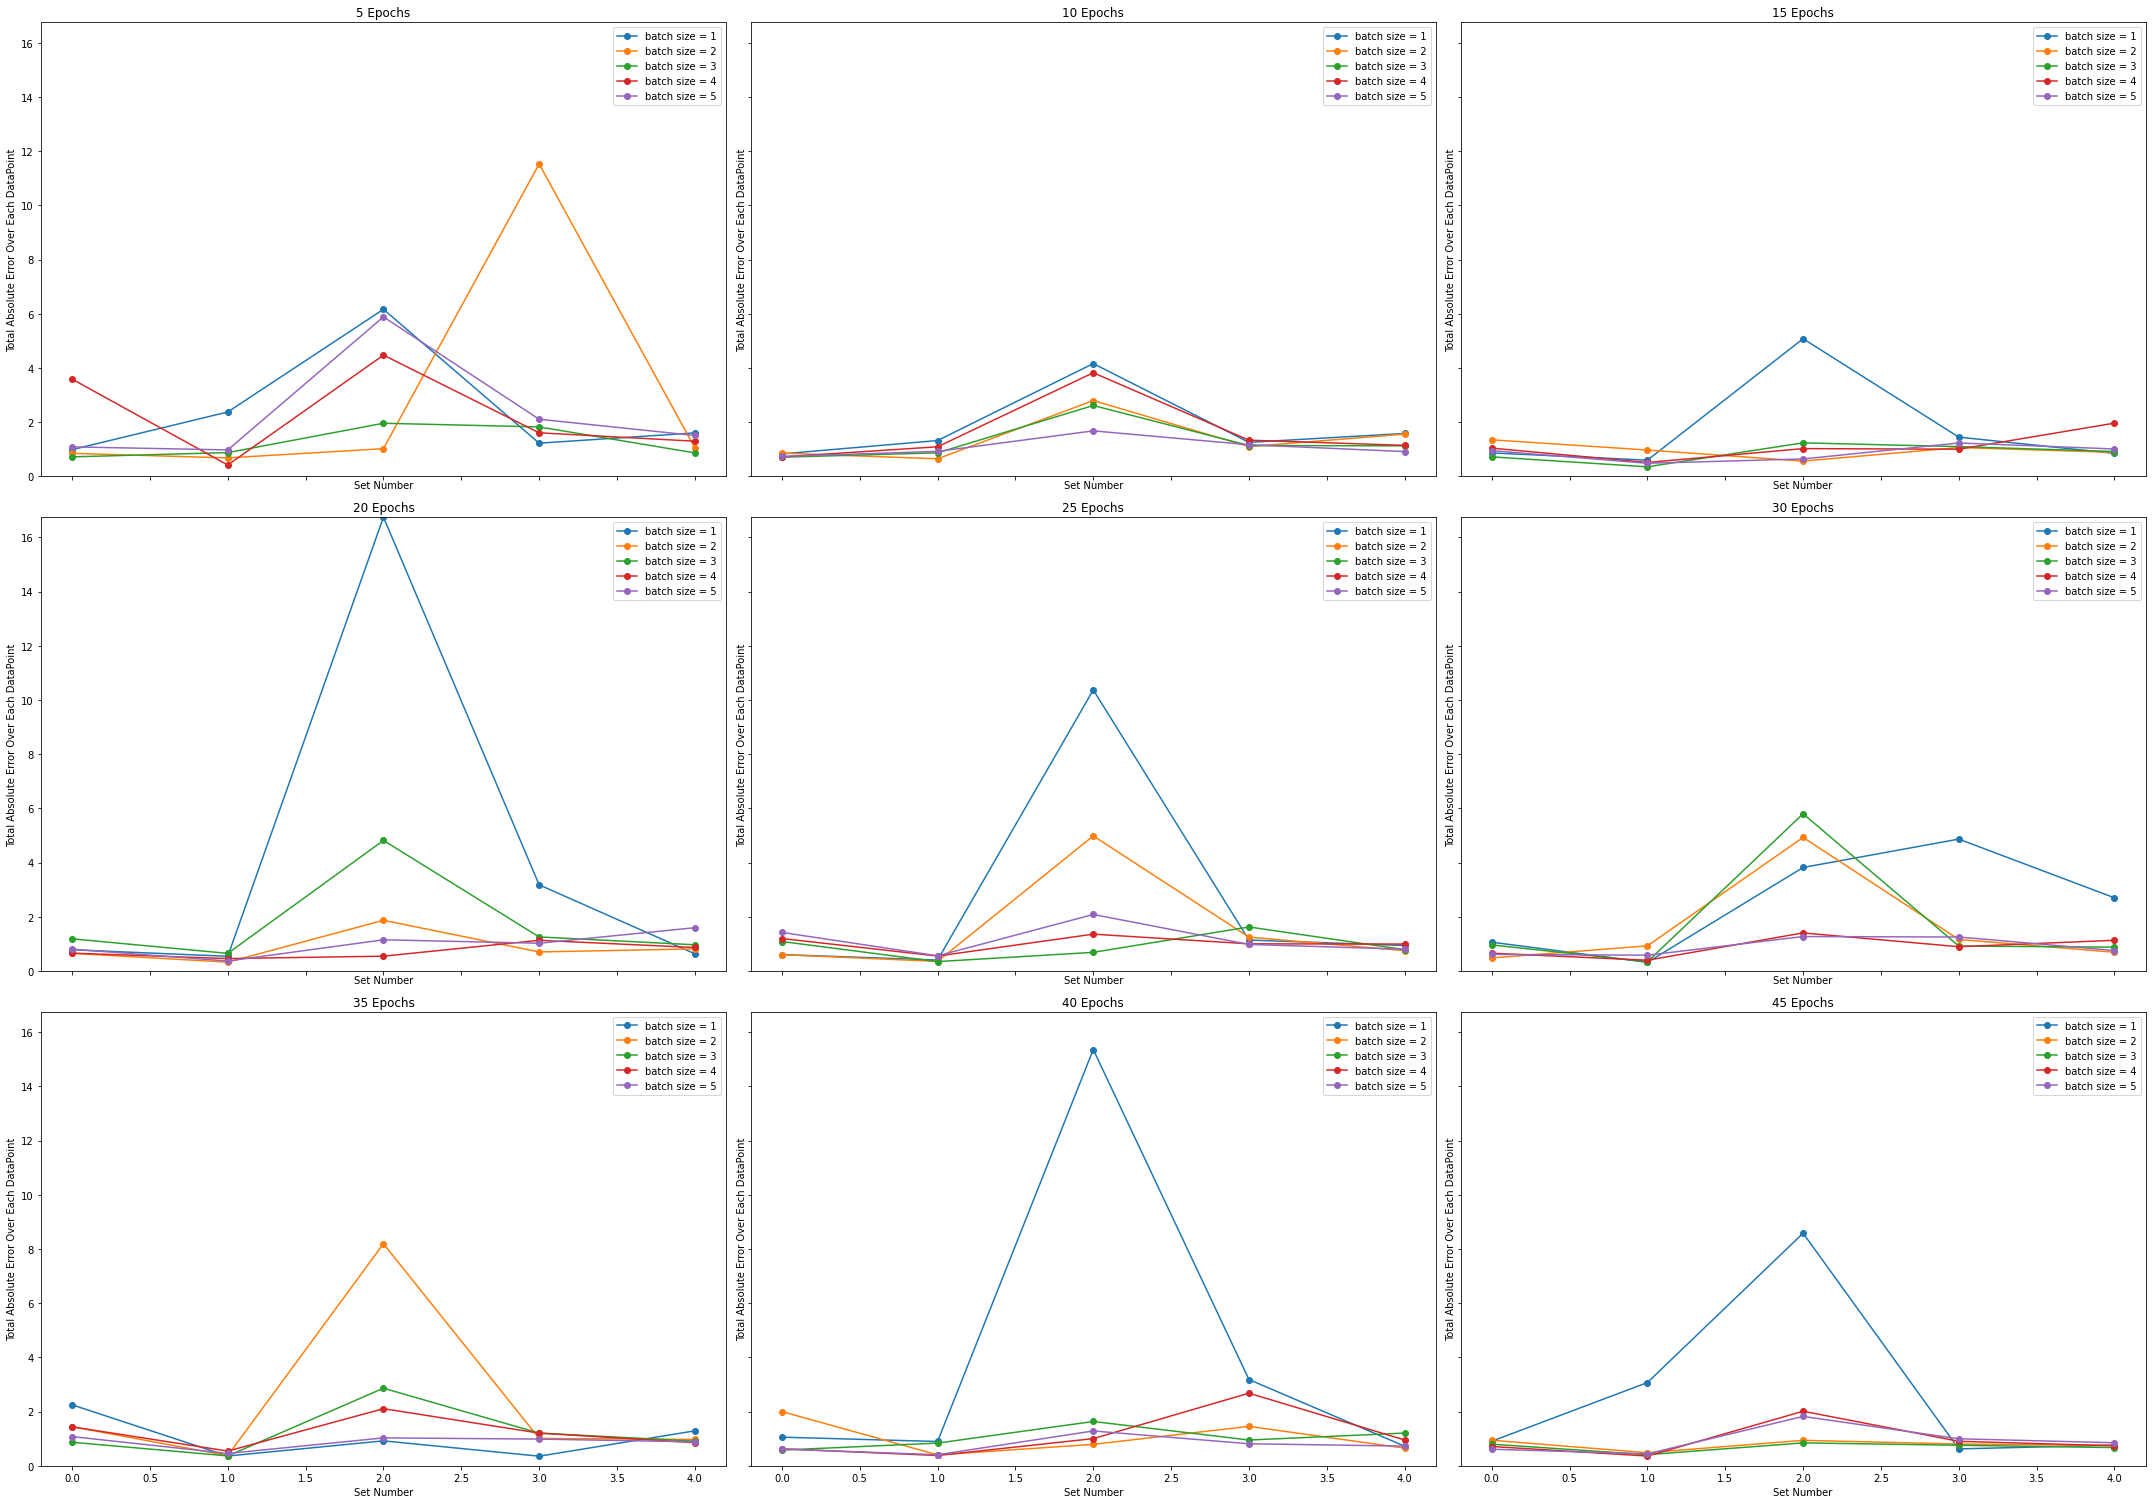

In [46]:
fig, ax = plt.subplots(3,3, figsize=(10*3,7*3), sharex=True, sharey=True);
for i in range(9):
  ax[i//3][i%3].set_title(str((i+1)*5) + " Epochs");
  ax[i//3][i%3].set_ylim(bottom = 0, top = max(total_errors.values()));
  ax[i//3][i%3].set_ylabel("Total Absolute Error Over Each DataPoint");
  ax[i//3][i%3].set_xlabel("Set Number");
  for j in range(5):
    ax[i//3][i%3].plot(by_batch_size[i][j], label="batch size = " + str(j + 1), marker='o');
    ax[i//3][i%3].legend(loc='top right');
plt.tight_layout();

In [18]:
find_best = 

{(5, 1, 0): 0.983853995301628,
 (5, 1, 1): 2.3747631967742917,
 (5, 1, 2): 6.163880677022744,
 (5, 1, 3): 1.2231673083213628,
 (5, 1, 4): 1.6034068650440214,
 (5, 2, 0): 0.8485549530665161,
 (5, 2, 1): 0.6805255312977315,
 (5, 2, 2): 1.0205731464113712,
 (5, 2, 3): 11.52572512084389,
 (5, 2, 4): 1.0501516372767923,
 (5, 3, 0): 0.7185309519242765,
 (5, 3, 1): 0.8756908612187385,
 (5, 3, 2): 1.9586929328064202,
 (5, 3, 3): 1.8233176042648558,
 (5, 3, 4): 0.8650761851613523,
 (5, 4, 0): 3.5870747103456493,
 (5, 4, 1): 0.4179434916586635,
 (5, 4, 2): 4.472797194240284,
 (5, 4, 3): 1.6065430656093125,
 (5, 4, 4): 1.2960989855604765,
 (5, 5, 0): 1.086340861981058,
 (5, 5, 1): 0.9745008945029258,
 (5, 5, 2): 5.883407435319613,
 (5, 5, 3): 2.10670778965497,
 (5, 5, 4): 1.5071722983948228,
 (10, 1, 0): 0.8279524924837588,
 (10, 1, 1): 1.3214324868553162,
 (10, 1, 2): 4.160559544670392,
 (10, 1, 3): 1.2537719649643897,
 (10, 1, 4): 1.5813902996114728,
 (10, 2, 0): 0.8556184681620597,
 (10, 2, 1)

In [ ]:
newdf = pd.DataFrame(by_set)
newdf

0          1         2         3
0  2.334997  -0.893499  0.417656  0.020302
1  2.796165  -1.083397  0.249943  0.006422
2  1.052445  -4.766287  7.252744  0.493498
3  3.514519  11.976687  1.511317  0.085163
4  2.096832   0.605659  1.966028  0.081438

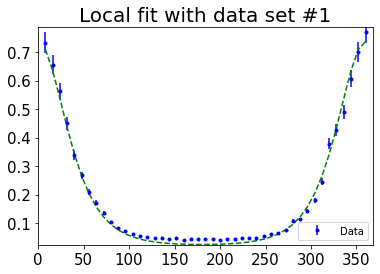

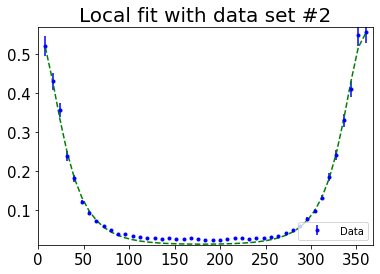

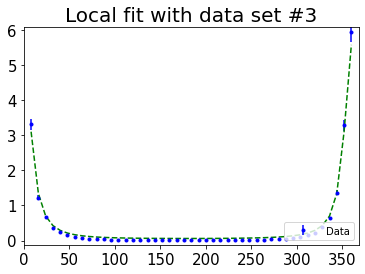

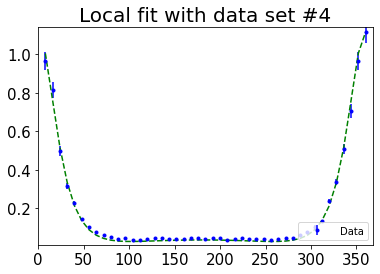

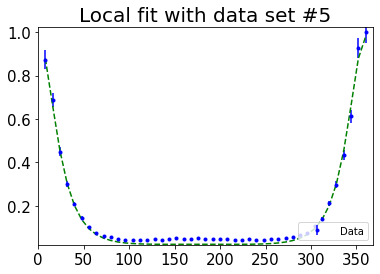

In [ ]:
by_set = []
for i in range(5):
  setI = data.getSet(i, itemsInSet=45)

  tfModel.set_weights(Wsave)

  tfModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleY(), # one replica of samples from F vals
                        epochs=15*5, verbose=0, batch_size=5, callbacks=[early_stopping_callback])
  
  
  cffs = cffs_from_globalModel(tfModel, setI.Kinematics, numHL=2)

  by_set.append(cffs)

  new_xdat = np.transpose(setI.XnoCFF.to_numpy(dtype=np.float32)) #NB: Could rewrite BHDVCS curve_fit to not require transposition

  # Avoid recalculating F-values from cffs when that is what the model is predicting already
  F2VsPhi(df,i+1,new_xdat,cffs);